# Liesel-GAM Demo Notebook

## Setup and Imports

The rpy2 Jupyter cell magic is used here only to pull the mcycle dataframe from R

In [3]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
from smoothcon import SmoothCon

import liesel_gam as gam

In [5]:
mcycle = None
%R -o mcycle library(MASS); data(mcycle)

array(['mcycle'], dtype='<U6')

In [6]:
mcycle.head()

,times,accel
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


In [7]:
# standardize
mcycle["times"] = (mcycle["times"] - mcycle["times"].mean()) / mcycle["times"].std()
mcycle["accel"] = (mcycle["accel"] - mcycle["accel"].mean()) / mcycle["accel"].std()

## Model Definition

The `gam.Sum()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [8]:
loc = gam.Sum("$\\mu$")
log_scale = gam.Sum("$\\log \\sigma$")


scale = lsl.Var.new_calc(jnp.exp, log_scale, name="$\\sigma$")

accel = lsl.Var.new_obs(
    value=mcycle.accel.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="accel",
)

### Add intercepts

In [9]:
loc += lsl.Var.new_param(
    value=0.0,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="$\\beta_0$",
)

log_scale += lsl.Var.new_param(
    value=0.0,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="$\\gamma_0$",
)

### Pull basis and penalty from mgcv

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [10]:
stimes = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(times, bs='ps', k=20, m=c(3,2))",
    data=mcycle,
)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [11]:
# we use the same basis for both smooths here
times_basis = lsl.Var.new_obs(stimes.basis, name="B(times)")

loc += gam.SmoothTerm.new_ig(
    basis=times_basis,
    penalty=stimes.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(times)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

log_scale += gam.SmoothTerm.new_ig(
    basis=times_basis,
    penalty=stimes.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(times)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="accel_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(times)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


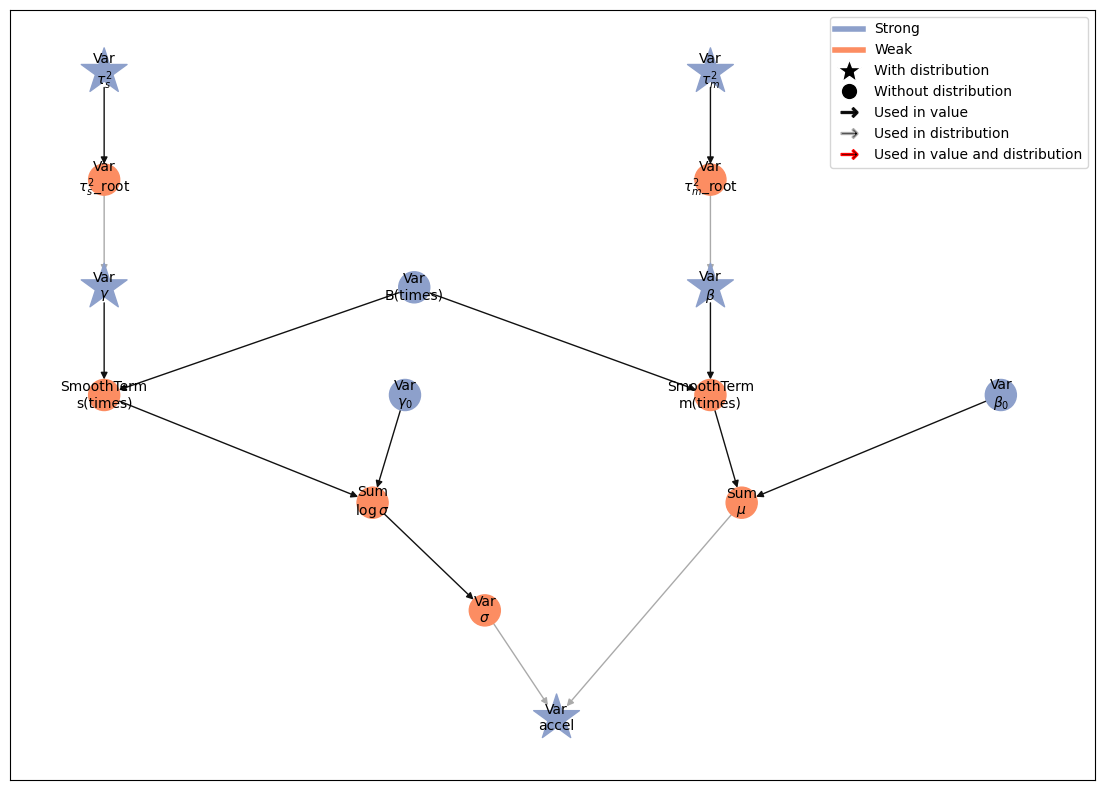

In [12]:
model = lsl.Model([accel])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [13]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.53chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 4, 2, 2, 2 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 1, 2, 1, 4 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 111.00chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 1, 1, 0 / 25 transitions
liesel.goose.engin

### MCMC summary

In [14]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_03  0.196401  0.308409 -0.289426  0.190178  0.697280   
           (1,)   kernel_03  0.375037  0.293295 -0.079396  0.359416  0.865382   
           (2,)   kernel_03 -0.136899  0.287819 -0.602728 -0.143368  0.346408   
           (3,)   kernel_03  0.109444  0.276851 -0.326730  0.103569  0.576962   
           (4,)   kernel_03 -0.206529  0.264052 -0.659149 -0.204032  0.212625   
           (5,)   kernel_03  0.228065  0.244614 -0.171191  0.226555  0.624541   
           (6,)   kernel_03  0.087580  0.232797 -0.295253  0.090397  0.466844   
           (7,)   kernel_03 -0.117217  0.213834 -0.468247 -0.118867  0.232582   
           (8,)   kernel_03  0.331598  0.206251  0.001460  0.325924  0.686395   
           (9,)   kernel_03 -0.530199  0.185910 -0.841298 -0.525138 -0.227090   
           (10,)  kernel_03  0.066880  0.164843 -0.202177  0.068255  0.331524   
           (11,)  kernel_03 -0.538740  0.144438 -0.779461 -0.536324 -0.299637   
           (12,)  kernel_03  0.247864  0.122313  0.043921  0.249404  0.446418   
           (13,)  kernel_03 -0.187906  0.097104 -0.348664 -0.186674 -0.034609   
           (14,)  kernel_03  0.269088  0.074596  0.149610  0.269071  0.389346   
           (15,)  kernel_03  0.042977  0.049963 -0.040079  0.043627  0.123375   
           (16,)  kernel_03  0.053895  0.028062  0.009012  0.053400  0.097631   
           (17,)  kernel_03 -0.021517  0.010892 -0.038885 -0.021705 -0.004246   
           (18,)  kernel_03  0.068480  0.042296  0.001252  0.068807  0.136723   
$\beta_0$  ()     kernel_05  0.003128  0.040132 -0.063340  0.002900  0.070170   
$\gamma$   (0,)   kernel_00 -0.030114  0.273942 -0.485269 -0.019223  0.389016   
           (1,)   kernel_00 -0.072963  0.276733 -0.534635 -0.062993  0.343661   
           (2,)   kernel_00  0.061847  0.278330 -0.352751  0.044818  0.538893   
           (3,)   kernel_00  0.087679  0.276242 -0.325080  0.066644  0.558104   
           (4,)   kernel_00  0.099418  0.270230 -0.287808  0.071586  0.585279   
           (5,)   kernel_00  0.072573  0.254815 -0.321389  0.067575  0.505110   
           (6,)   kernel_00  0.180312  0.265602 -0.202281  0.156144  0.660910   
           (7,)   kernel_00 -0.047862  0.235428 -0.432706 -0.038181  0.305825   
           (8,)   kernel_00  0.146216  0.241578 -0.201848  0.120289  0.578268   
           (9,)   kernel_00 -0.150402  0.216676 -0.505425 -0.140228  0.180536   
           (10,)  kernel_00 -0.290073  0.199056 -0.633265 -0.278825  0.003007   
           (11,)  kernel_00  0.073330  0.190192 -0.236605  0.075593  0.379179   
           (12,)  kernel_00  0.260516  0.177843 -0.000124  0.244498  0.565915   
           (13,)  kernel_00  0.169995  0.156781 -0.081303  0.169488  0.428666   
           (14,)  kernel_00 -0.190608  0.140698 -0.437189 -0.182123  0.020634   
           (15,)  kernel_00  0.087742  0.096521 -0.065840  0.086646  0.247633   
           (16,)  kernel_00  0.013995  0.061371 -0.079587  0.009462  0.121345   
           (17,)  kernel_00  0.059326  0.023837  0.019145  0.059764  0.096709   
           (18,)  kernel_00  0.087317  0.094964 -0.076732  0.091223  0.235618   
$\gamma_0$ ()     kernel_02 -1.193700  0.071936 -1.308976 -1.194685 -1.072934   
$\tau^2_m$ ()     kernel_04  0.120948  0.061560  0.053702  0.106659  0.237248   
$\tau^2_s$ ()     kernel_01  0.075439  0.070205  0.014953  0.056068  0.198720   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3279.512567  3555.739096  1.001190  
           (1,)          4000  3128.977511  3619.195343  0.999782  
           (2,)          4000  3007.277860  3273.789025  1.000167  
           (3,)          4000  3129.320900  3840.916035  1.000173  
       

### MCMC trace plots

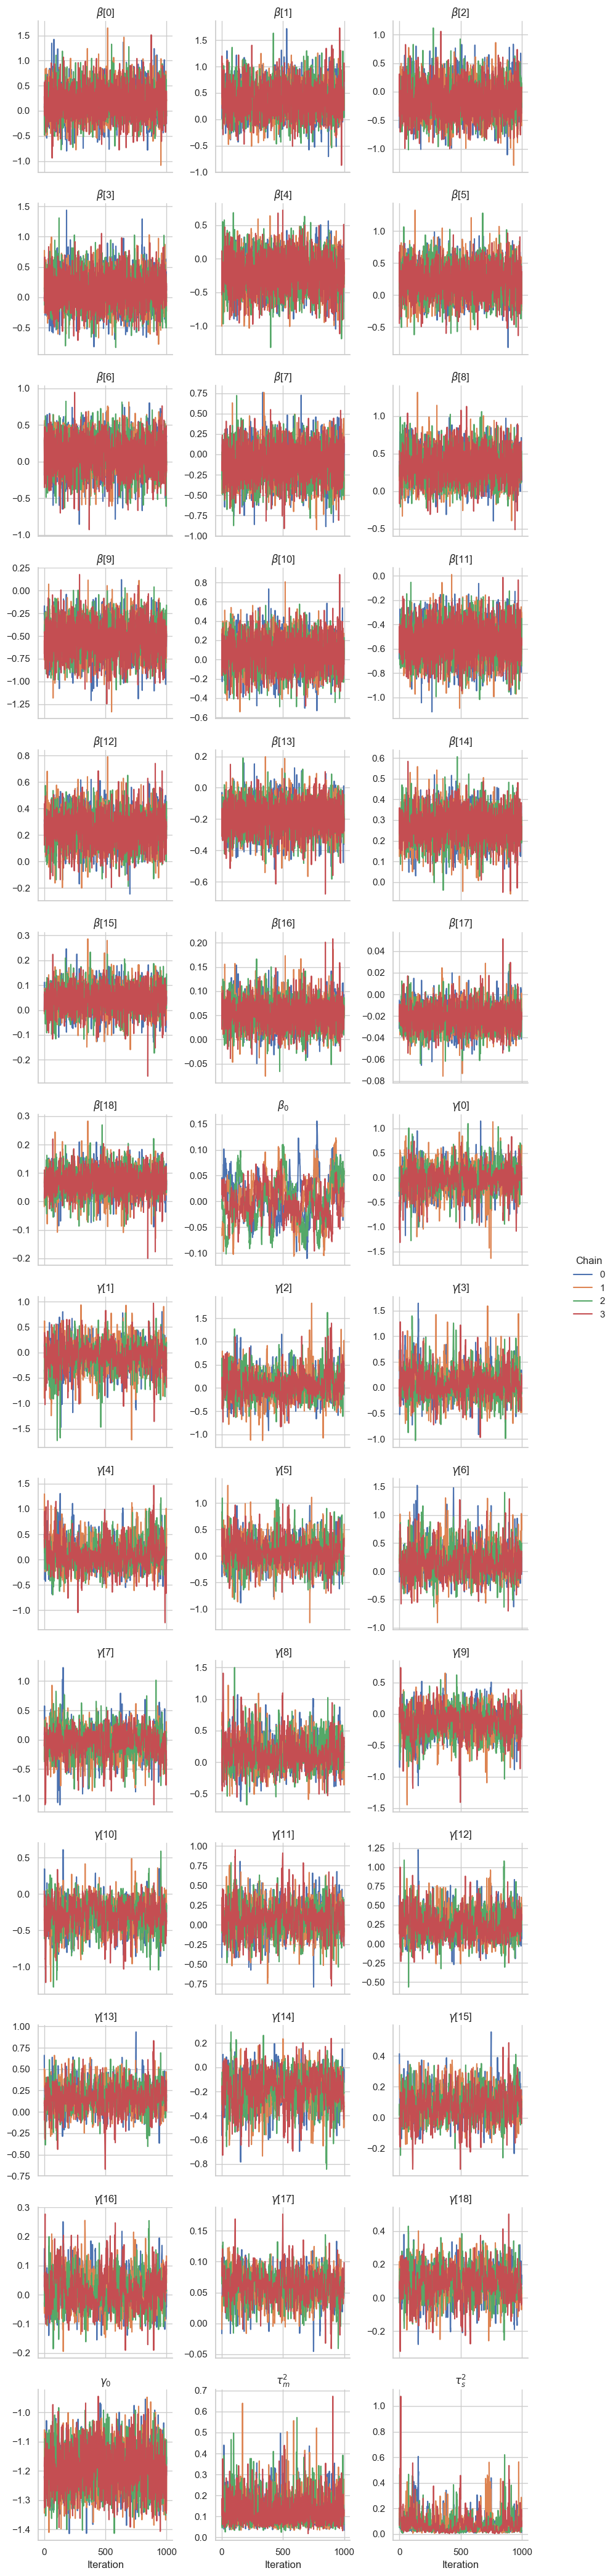

In [15]:
gs.plot_trace(results)

## Predictions

In [16]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We again use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [17]:
times_grid = jnp.linspace(mcycle.times.min(), mcycle.times.max(), 200)
B_times_grid = stimes.predict(data={"times": times_grid})

### Predict variables at new x values

In [18]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(times)", "s(times)", "$\\mu$", "$\\sigma$"],
    newdata={"B(times)": B_times_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["times"] = np.tile(times_grid, len(predictions))

In [19]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,times
0,$\mu$,$\mu$[0],"(0,)",4000,0.519710,0.000554,0.023534,1.003362,3449.235781,2804.435188,0.000398,0.000613,0.482840,0.519154,0.558664,0.482157,0.557654,-1.734605
1,$\mu$,$\mu$[1],"(1,)",4000,0.511228,0.000324,0.018014,1.002019,3482.836687,2766.259720,0.000305,0.000509,0.483396,0.511100,0.540802,0.480514,0.537579,-1.713482
2,$\mu$,$\mu$[2],"(2,)",4000,0.503464,0.000226,0.015040,1.001475,3522.438275,2848.966010,0.000254,0.000413,0.480197,0.503479,0.527334,0.480087,0.527213,-1.692360
3,$\mu$,$\mu$[3],"(3,)",4000,0.496579,0.000197,0.014048,1.000620,3441.380475,2797.716001,0.000241,0.000329,0.474071,0.496737,0.519427,0.474719,0.519842,-1.671237
4,$\mu$,$\mu$[4],"(4,)",4000,0.490692,0.000205,0.014332,1.000902,3225.408755,2877.591841,0.000253,0.000278,0.467100,0.490697,0.513755,0.467611,0.513988,-1.650114


### Plot fitted functions

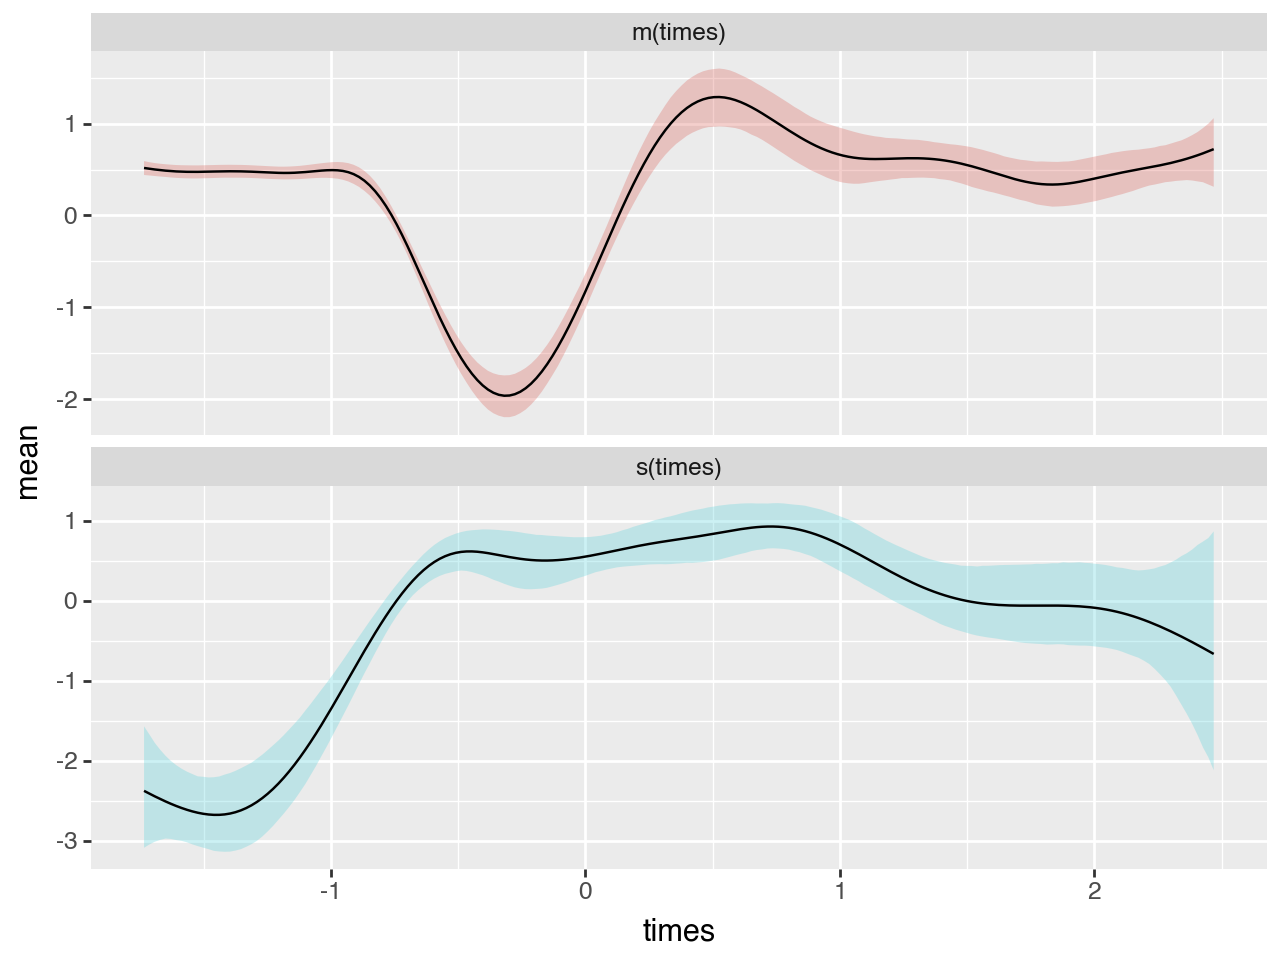

In [20]:
select = predictions_summary["variable"].isin(["s(times)", "m(times)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

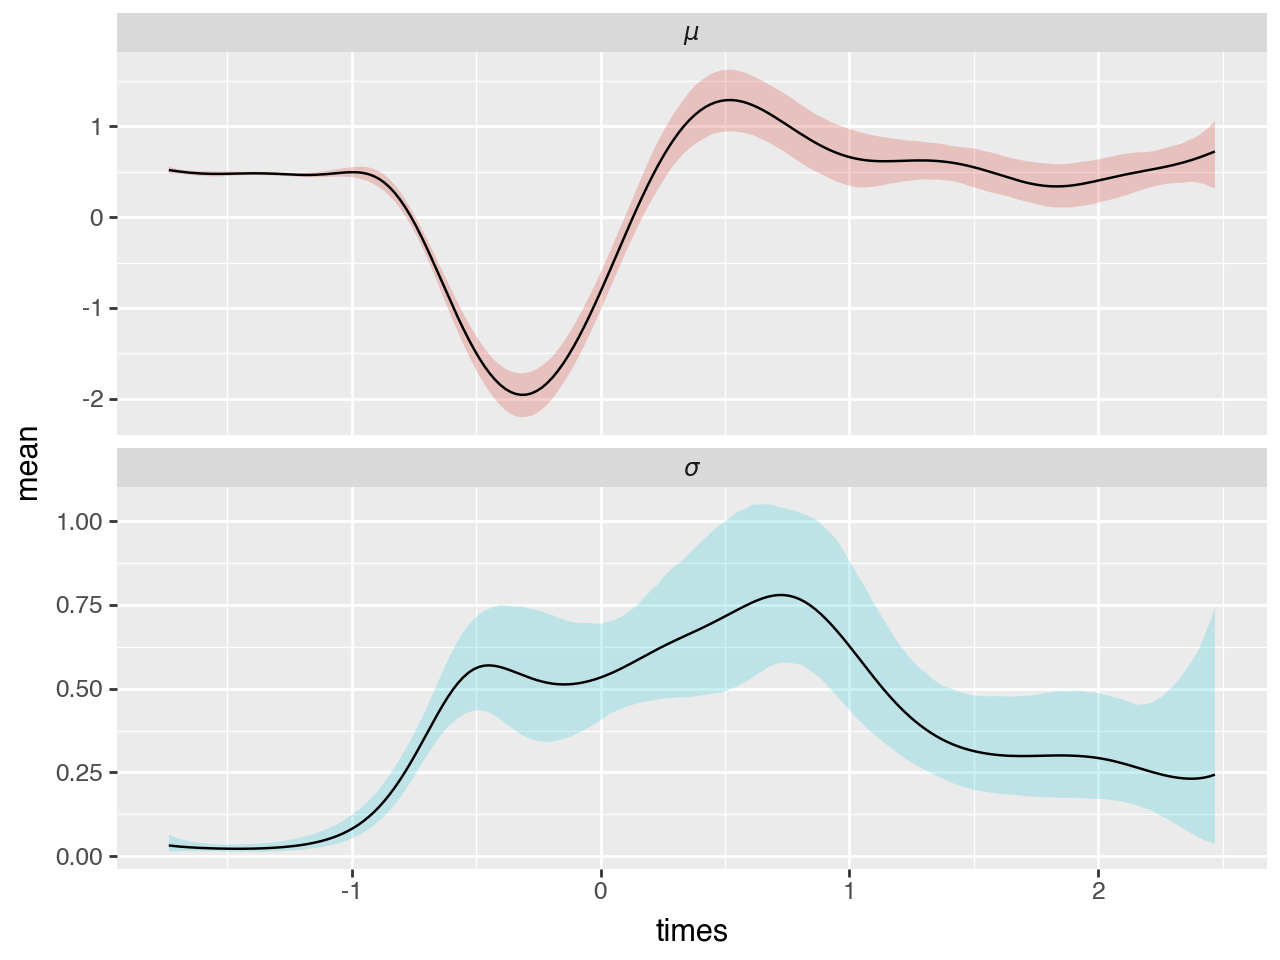

In [21]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

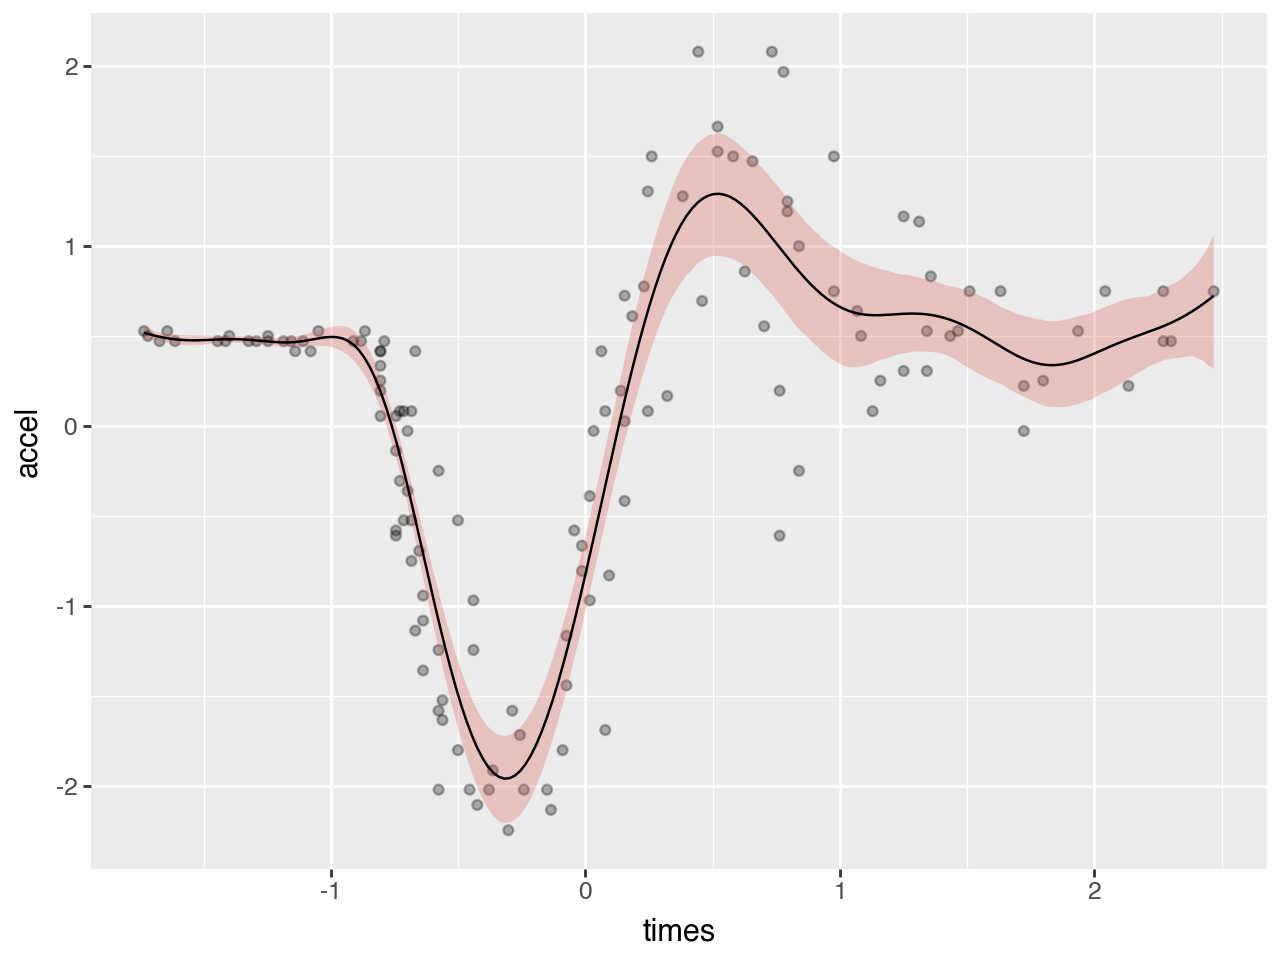

In [22]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [23]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "times"]]
    .pivot(index="times", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,times,$\mu$,$\sigma$,low,high
0,-1.734605,0.519710,0.031655,0.488055,0.551365
1,-1.713482,0.511228,0.029923,0.481306,0.541151
2,-1.692360,0.503464,0.028448,0.475016,0.531913
3,-1.671237,0.496579,0.027188,0.469392,0.523767
4,-1.650114,0.490692,0.026107,0.464585,0.516798
...,...,...,...,...,...
195,2.384355,0.638603,0.231156,0.407447,0.869758
196,2.405478,0.658125,0.232179,0.425946,0.890304
197,2.426601,0.679011,0.234411,0.444600,0.913423
198,2.447724,0.701212,0.238041,0.463170,0.939253


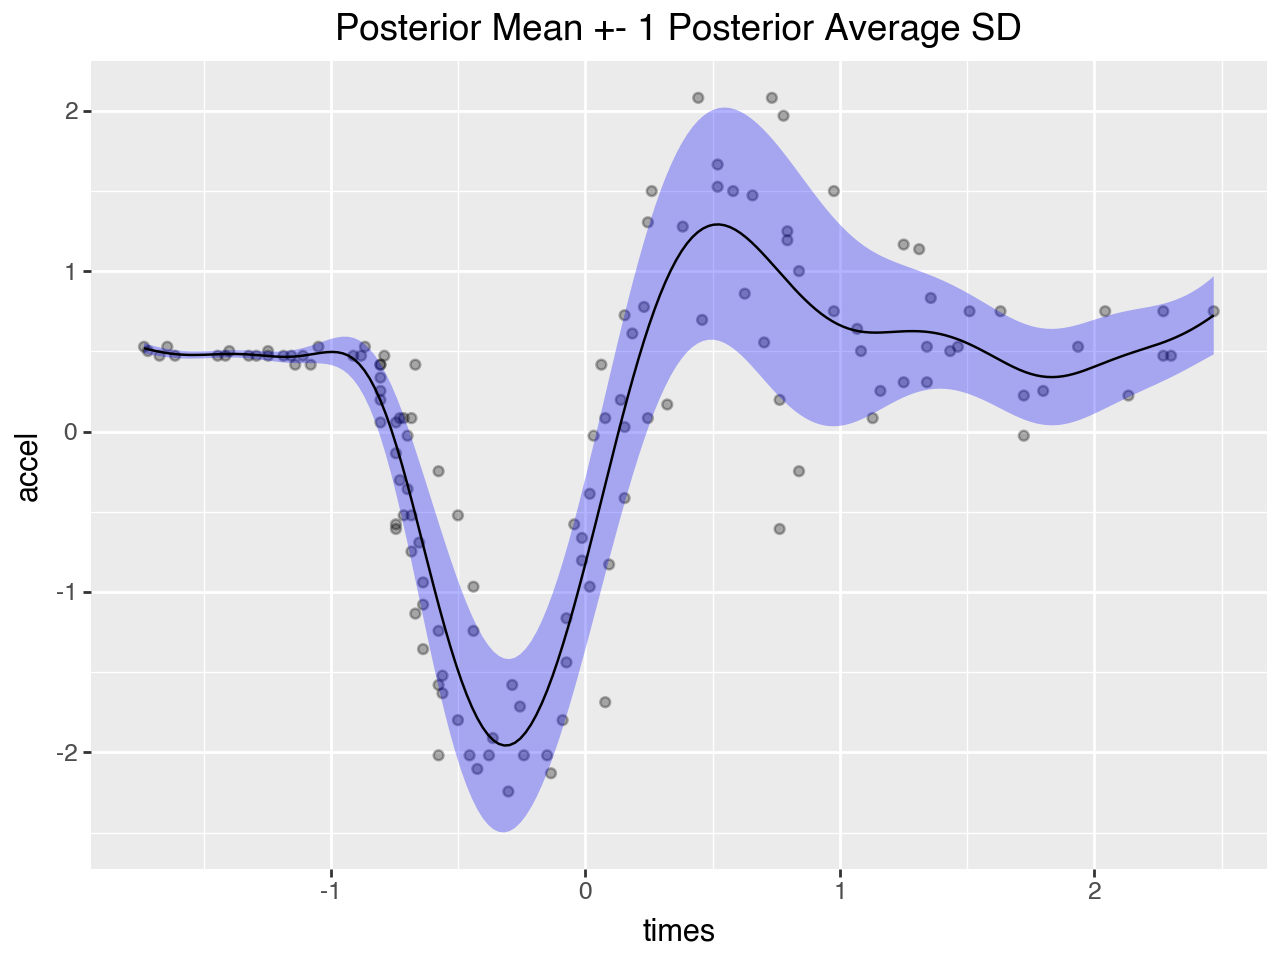

In [24]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("times", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [25]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["accel"].shape

(3, 4, 1000, 133)

In [26]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["accel"].reshape(-1, *ppsamples["accel"].shape[2:])

### Summarize posterior predictive samples

In [27]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["times"] = mcycle["times"].to_numpy()

### Plot posterior predictive summary

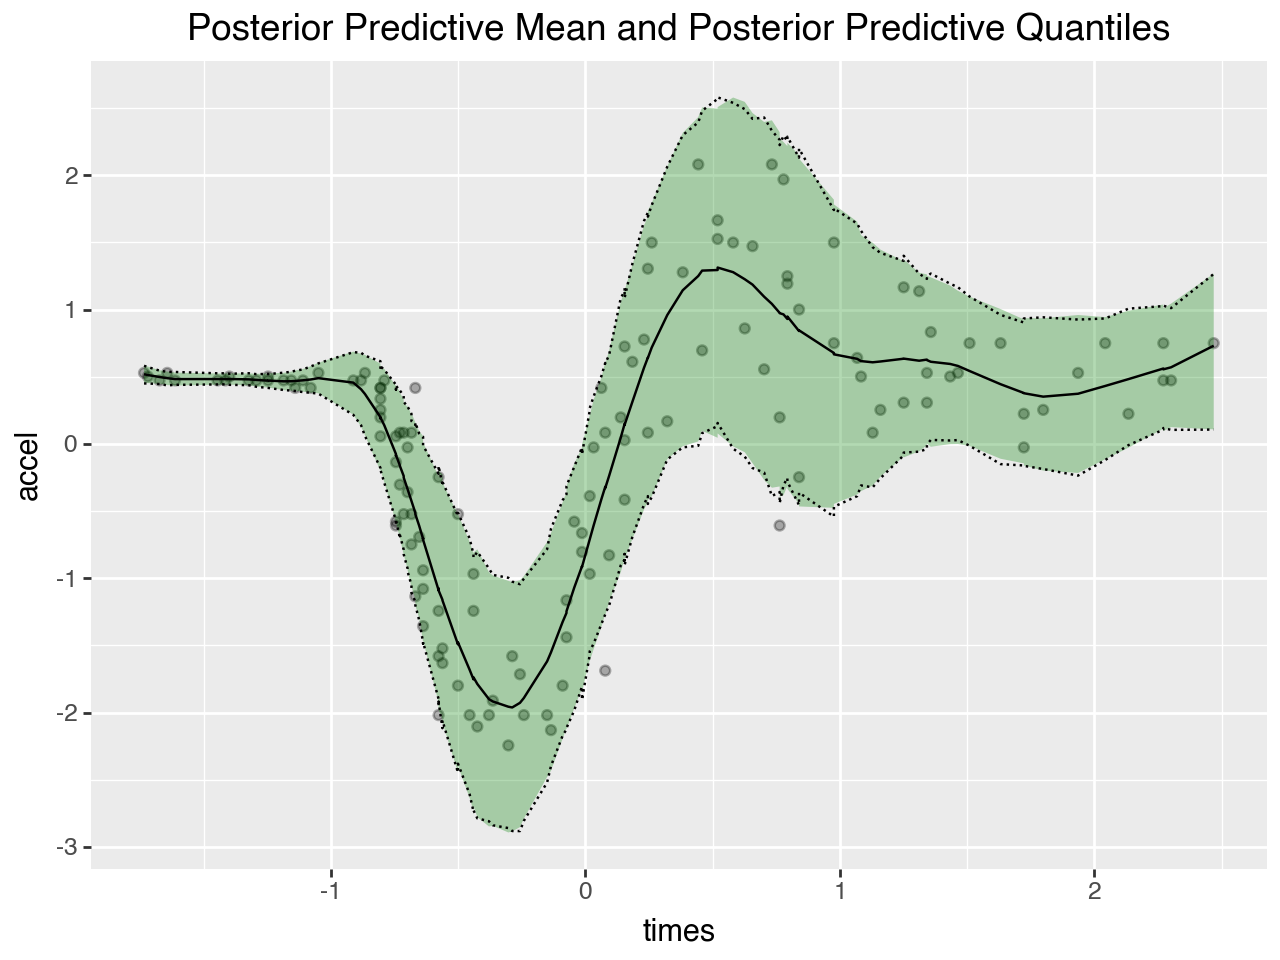

In [28]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("times", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("times", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

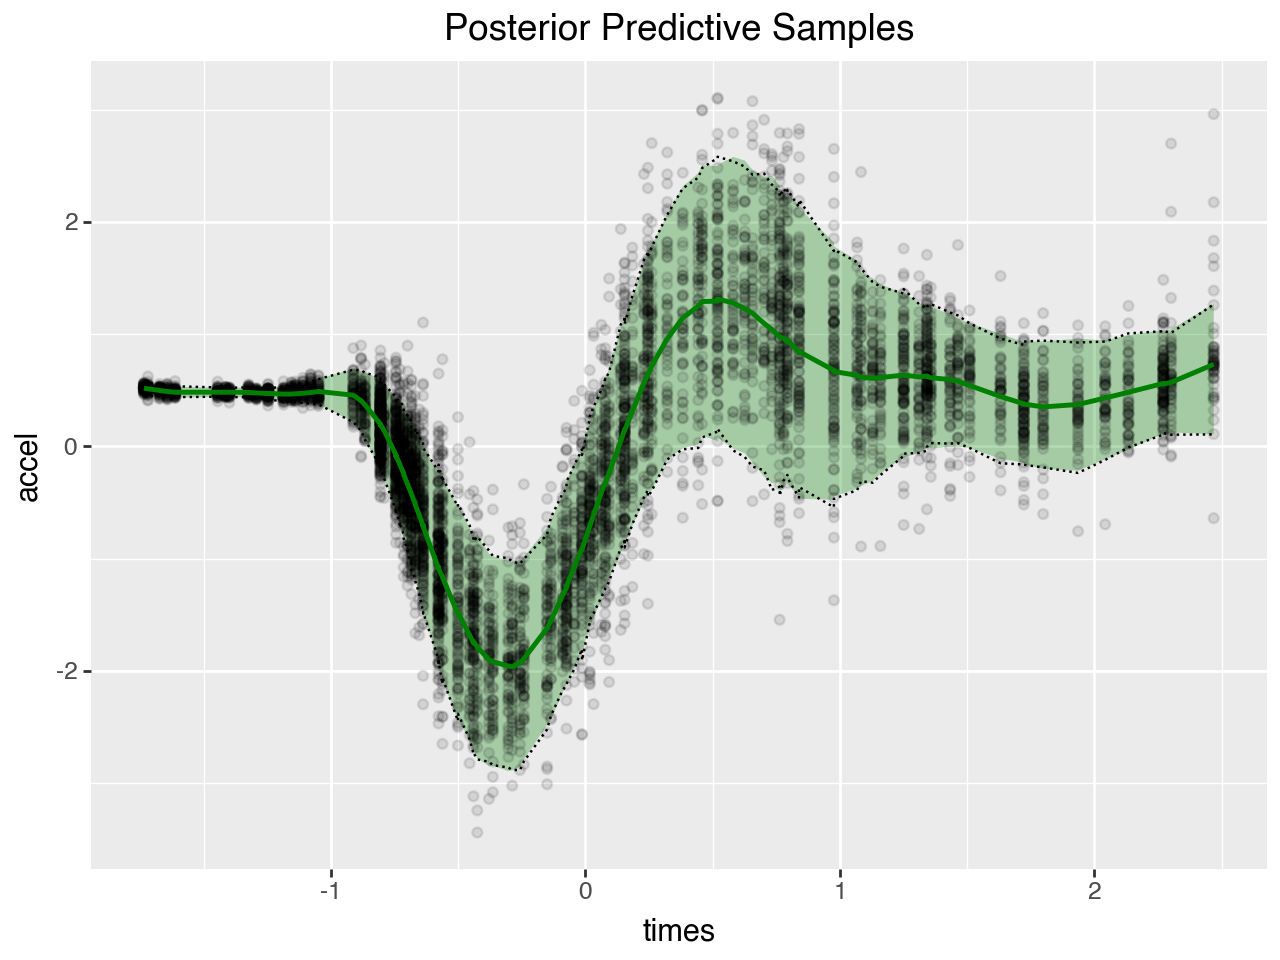

In [29]:
ppsamples_reshaped = ppsamples["accel"].reshape(-1, *ppsamples["accel"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["times"] = mcycle["times"].to_numpy()
ppsamples_df = ppsamples_df.melt(
    id_vars=["times"], value_name="accel", var_name="sample"
)
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("times", "accel"), alpha=0.1)
    + p9.geom_line(
        p9.aes("times", "hdi_low"), linetype="dotted", data=ppsamples_summary
    )
    + p9.geom_line(
        p9.aes("times", "hdi_high"), linetype="dotted", data=ppsamples_summary
    )
    + p9.geom_line(
        p9.aes("times", "mean"), color="green", size=1, data=ppsamples_summary
    )
)